### Mettez vos implémentations ci-dessous (Fonctions d'activation / de perte, couche de neurones, réseau)

In [1]:
import numpy as np

### Chargeons les données et observons-les

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])


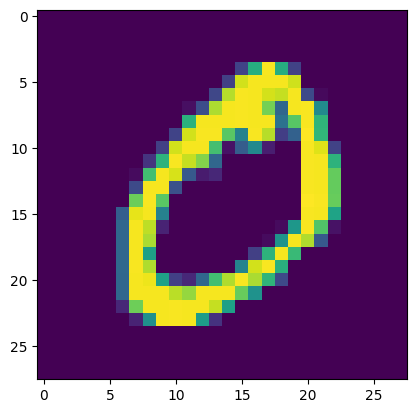

In [2]:
import tensorflow as tf #Librairie de réseau de neurones, pour récupérer le jeu de données
import matplotlib.pyplot as plt
import pprint
mnist = tf.keras.datasets.mnist
train_data, test_data = mnist.load_data()

# Séparation données d'entraînement / de test
train_images, train_labels = train_data
test_images, test_labels = test_data
     
# Préparation des données
X_train = train_images.reshape((60000, 784))
X_train = X_train.astype('float32') / 255
X_test = test_images.reshape((10000, 784))
X_test = X_test.astype('float32') / 255
     
y_train = tf.keras.utils.to_categorical(train_labels)
y_test = tf.keras.utils.to_categorical(test_labels)

pprint.pprint(y_train)
# Regardons à quoi ça ressemble
plt.imshow(train_images[1])
plt.show()

### Créez un réseau et fittez-le sur vos données d'entraînement avant de tester sur vos données de test.

Commencez par prédire les 0 (étiquette = 1 dans la première colonne de y_train) puis prédire tous les nombres. 

Testez plusieurs structures de réseau (différentes tailles (nb de couches + taille des chouches), fonction d'activation ReLu plutôt que sigmoïde). Commentez vos résultats (en parlant de surapprentissage,.

### Créez un réseau et fittez-le sur vos données d'entraînement avant de tester sur vos données de test.

Commencez par prédire les 0 (étiquette = 1 dans la première colonne de y_train) puis prédire tous les nombres. 

Testez plusieurs structures de réseau (différentes tailles (nb de couches + taille des chouches), fonction d'activation ReLu plutôt que sigmoïde). Commentez vos résultats (en parlant de surapprentissage,.

In [3]:
class activation:
    def __init__(self, function, derivative):
        self.function = function
        self.derivative = derivative

sigmoid = activation(lambda x : 1/(1+np.exp(-x)), lambda x : np.exp(-x)/((1+np.exp(-x))**2))
identity = activation(lambda x : x, lambda x : 1)
relu     = activation(lambda x: np.maximum(0, x),
                      lambda x: (x > 0).astype(float))

class layer:
    def __init__(self, size_in, size_out, activation_function):
        self.entry = np.zeros([size_in])
        self.weights = np.random.normal(size=[size_out, size_in])
        self.gradient_weights = np.zeros([size_out, size_in])
        self.bias = np.random.normal(size=[size_out])
        self.gradient_bias = np.zeros([size_out])
        self.activation = activation_function
        
    def output(self):
        return self.activation.function(self.weights @ self.entry + self.bias)
    
    def derivate(self):
        return self.activation.derivative(self.weights @ self.entry + self.bias)
    
    def descend(self, step_length):
        self.weights -= step_length * self.gradient_weights
        self.bias -= step_length * self.gradient_bias
        
        # Reset gradients
        self.gradient_weights = np.zeros([self.weights.shape[0], self.weights.shape[1]])
        self.gradient_bias = np.zeros([self.bias.shape[0]])

class network:
    def __init__(self):
        self.layers = []
        
    def add_layer(self,size_in, size_out, activation_function):
        new_layer = layer(size_in, size_out, activation_function)
        self.layers.append(new_layer)
        
    def run(self,x):
        output = np.copy(x) #Par défaut, numpy ne fait pas de copies lors des attributions
        for layer in self.layers:
            layer.entry = np.copy(output)
            output = np.copy(layer.output())
        return output
    
    def fit(self,training_data, training_labels, nb_steps, step_length):
        n = training_data.shape[0]
        for i in range(nb_steps):
            loss = 0
            for j in range(n):
                output = self.run(training_data[j,:].transpose())
                H = -2 * (training_labels[j,:] - output)
                loss += np.sum(np.pow(training_labels[j,:] - output, 2))
                
                for layer in reversed(self.layers):
                    temp = layer.derivate()
                    layer.gradient_weights += np.outer(H * temp, layer.entry)
                    layer.gradient_bias += H * temp
                    H = layer.weights.transpose() @ (H * temp)
                    
            
            for layer in self.layers:
                layer.descend(step_length)
            
            if(i%100 == 0) : print(loss)

[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
44674.0373077436
Précision sur la détection des zéros: 90.20%


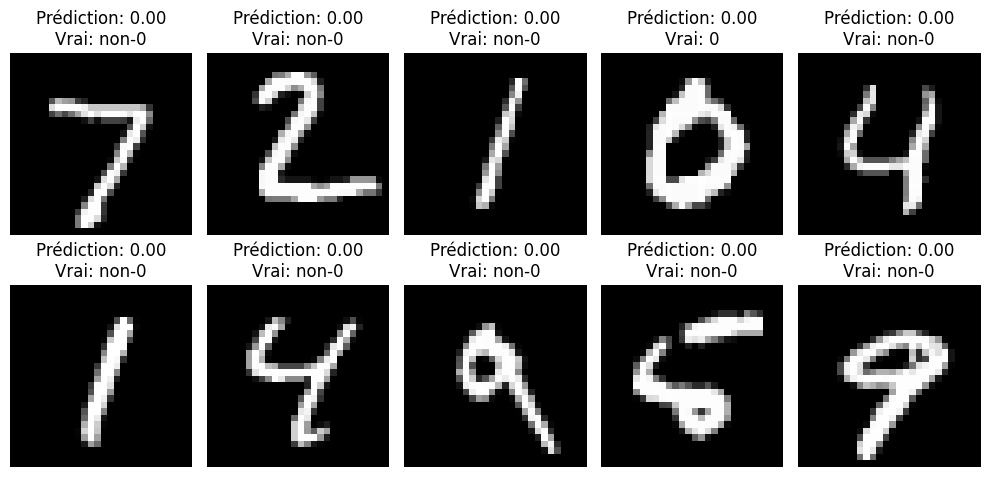

In [4]:
# Préparation pour la détection des zéros uniquement
# Extraire seulement la première colonne de y_train qui correspond aux zéros
y_train_zero = y_train[:, 0].reshape(-1, 1)  # Extraire la colonne des zéros et la transformer en vecteur colonne
y_test_zero = y_test[:, 0].reshape(-1, 1)    # Idem pour les données de test
print(y_train_zero)
# # Créer un réseau avec moins de neurones et un taux d'apprentissage plus faible
NN = network()
NN.add_layer(784, 20, relu)      # Utiliser relu au lieu de identity
NN.add_layer(20, 1, sigmoid)     # Une seule sortie pour détecter les zéros

# # Entraînement avec moins d'étapes et un taux d'apprentissage plus faible
# # pour éviter les problèmes d'overflow
NN.fit(X_train, y_train_zero, 20, 1e-4)

# # Test du modèle sur l'ensemble de test (pas d'entraînement)
n_test = X_test.shape[0]
y_pred = np.zeros(n_test)

for j in range(n_test):
    #Prédiction avec le modèle entraîné
    output = NN.run(X_test[j,:])
    y_pred[j] = output[0]  # La première (et unique) valeur de sortie

# # Évaluation des performances
pred_class = (y_pred > 0.5).astype(int)
true_class = y_test_zero.reshape(-1)
accuracy = np.mean(pred_class == true_class)

print(f"Précision sur la détection des zéros: {accuracy * 100:.2f}%")

# # Afficher quelques exemples
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f"Prédiction: {y_pred[i]:.2f}\nVrai: {'0' if true_class[i]==1 else 'non-0'}")
    plt.axis('off')
plt.tight_layout()
plt.show()